<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-Method/blob/main/Hybrid_VARX_LSTM_SW3BLNAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Input Data**

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
from google.colab import drive


import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
file_path = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet2')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

Mounted at /content/drive
'Hybrid VARX_LSTM SW3BLNAS.ipynb'    'nyoba var-lstm.ipynb'  'wisman bali-kurs (1).xlsx'
'Hybrid VARX_LSTM SW3BLNGAB.ipynb'    Untitled0.ipynb	     'wisman bali-kurs.xlsx'
'Hybrid VARX_LSTM SW3BLNRAYA.ipynb'   VAR_YT.ipynb
             Kurs  Wisman Bali  Hari Libur Nasional
Date                                               
2023-01-01  15592        10626                    1
2023-01-02  15572        12338                    0
2023-01-03  15590        12122                    0
2023-01-04  15615        11957                    0
2023-01-05  15610        13463                    0


## **Praproses Data**

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[endog_vars] = scaler.fit_transform(df[endog_vars]) # Normalisasi hanya untuk variabel endogen
print(df_norm.head())


                Kurs  Wisman Bali  Hari Libur Nasional
Date                                                  
2023-01-01  0.525739     0.440566                    1
2023-01-02  0.514786     0.511547                    0
2023-01-03  0.524644     0.502591                    0
2023-01-04  0.538335     0.495750                    0
2023-01-05  0.535597     0.558191                    0


In [6]:
print("Min-Max Data Sebelum Normalisasi:")
print(df[endog_vars].min(), df[endog_vars].max())

print("\nMin-Max Data Setelah Normalisasi:")
print(df_norm[endog_vars].min(), df_norm[endog_vars].max())

Min-Max Data Sebelum Normalisasi:
Kurs           14632
Wisman Bali        0
dtype: int64 Kurs           16458
Wisman Bali    24119
dtype: int64

Min-Max Data Setelah Normalisasi:
Kurs           0.0
Wisman Bali    0.0
dtype: float64 Kurs           1.0
Wisman Bali    1.0
dtype: float64


## **Eksplorasi Data**

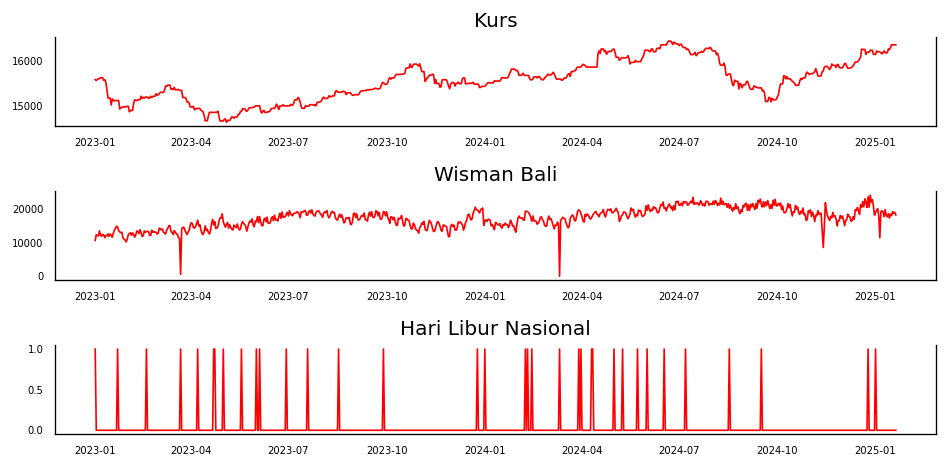

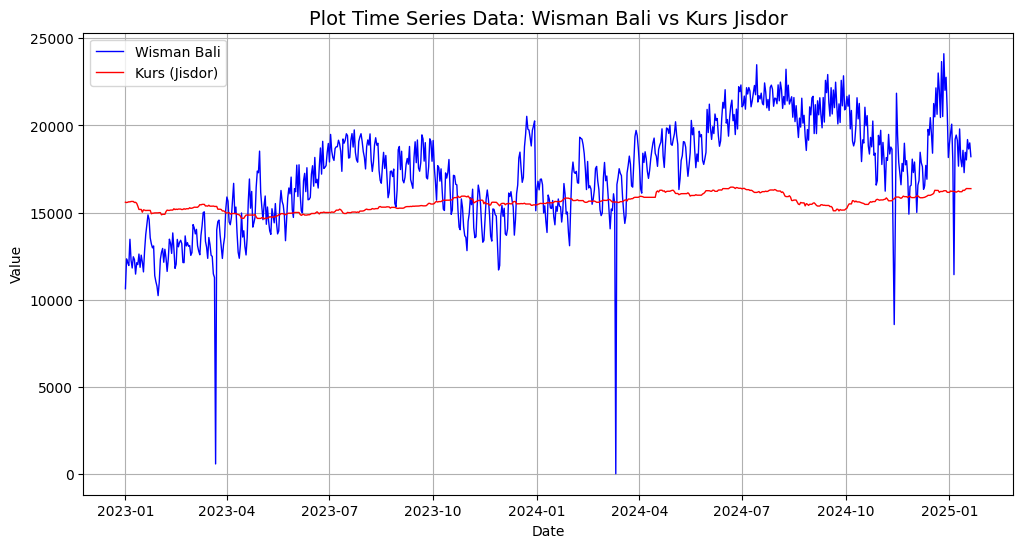

In [7]:
fig, axes = plt.subplots(nrows=3, dpi=120, figsize=(8, 4))

for i, ax in enumerate(axes):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Wisman Bali'], color='blue', linewidth=1, label='Wisman Bali')
plt.plot(df['Kurs'], color='red', linewidth=1, label='Kurs (Jisdor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Time Series Data: Wisman Bali vs Kurs Jisdor', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### **Uji Korelasi**

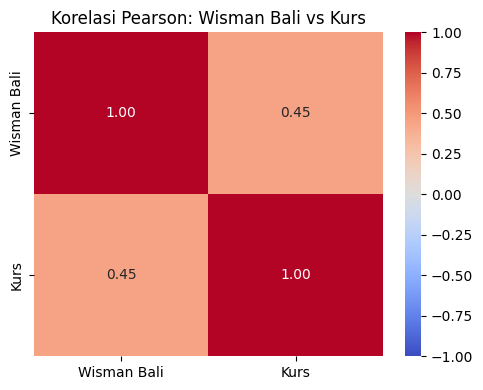

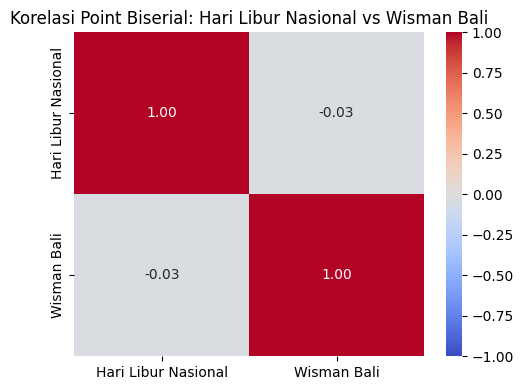

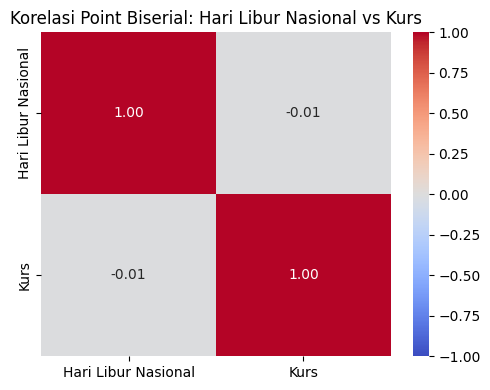

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, pointbiserialr

# Fungsi bantu untuk bikin heatmap 2x2
def plot_corr_heatmap(var1, var2, method, title):
    if method == 'pearson':
        corr_val, _ = pearsonr(df[var1], df[var2])
    elif method == 'biserial':
        corr_val, _ = pointbiserialr(df[var1], df[var2])

    corr_matrix = pd.DataFrame(
        [[1, corr_val], [corr_val, 1]],
        index=[var1, var2],
        columns=[var1, var2]
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Panggil fungsi untuk masing-masing pasangan ---
plot_corr_heatmap('Wisman Bali', 'Kurs', 'pearson', 'Korelasi Pearson: Wisman Bali vs Kurs')
plot_corr_heatmap('Hari Libur Nasional', 'Wisman Bali', 'biserial', 'Korelasi Point Biserial: Hari Libur Nasional vs Wisman Bali')
plot_corr_heatmap('Hari Libur Nasional', 'Kurs', 'biserial', 'Korelasi Point Biserial: Hari Libur Nasional vs Kurs')


### **Uji T**

In [9]:
from scipy.stats import ttest_ind

# Pisahkan data saat Hari Libur Nasional dan bukan
kurs_libnas = df[df['Hari Libur Nasional'] == 1]['Kurs']
kurs_non_libnas = df[df['Hari Libur Nasional'] == 0]['Kurs']

t_stat, p_value = ttest_ind(kurs_libnas, kurs_non_libnas)
print(f"T-test Kurs: p-value = {p_value}")

wisman_libnas = df[df['Hari Libur Nasional'] == 1]['Wisman Bali']
wisman_non_libnas = df[df['Hari Libur Nasional'] == 0]['Wisman Bali']

t_stat, p_value = ttest_ind(wisman_libnas, wisman_non_libnas)
print(f"T-test Wisman: p-value = {p_value}")


T-test Kurs: p-value = 0.773382181870725
T-test Wisman: p-value = 0.46666373133853833


In [10]:
def granger_test(df, dep_var, indep_var, maxlag=9):
    print(f"\n Uji Granger Causality: Apakah {indep_var} memengaruhi {dep_var}?")
    result = grangercausalitytests(df[[dep_var, indep_var]], maxlag=maxlag, verbose=False)

    for lag in range(1, maxlag + 1):
        p_value = result[lag][0]['ssr_ftest'][1]  # Ambil p-value dari SSR F-test

        if p_value < 0.05:
            print(f"v Lag {lag}: p-value = {p_value:.4f} (< 0.05), {indep_var} **menyebabkan** {dep_var}.")
        else:
            print(f"x Lag {lag}: p-value = {p_value:.4f} (>= 0.05), tidak ada bukti signifikan bahwa {indep_var} menyebabkan {dep_var}.")

# Panggil fungsi dengan variabel 'Hari Libur Nasional'
granger_test(df, 'Wisman Bali', 'Kurs', maxlag=9)
granger_test(df, 'Kurs', 'Wisman Bali', maxlag=9)
granger_test(df, 'Kurs', 'Hari Libur Nasional', maxlag=9)
granger_test(df, 'Wisman Bali', 'Hari Libur Nasional', maxlag=9)



 Uji Granger Causality: Apakah Kurs memengaruhi Wisman Bali?
v Lag 1: p-value = 0.0000 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 2: p-value = 0.0058 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 3: p-value = 0.0401 (< 0.05), Kurs **menyebabkan** Wisman Bali.
x Lag 4: p-value = 0.0968 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 5: p-value = 0.2857 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 6: p-value = 0.3563 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 7: p-value = 0.6418 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 8: p-value = 0.1637 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 9: p-value = 0.1942 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.

 Uji Granger Causality: Apakah Wisman Bali memengaruhi Kurs?
x Lag 1: p-value = 0.4593 (>= 0.05), tidak ada bukti signifikan ba

In [11]:
from statsmodels.tsa.stattools import coint
coint_result = coint(df['Kurs'], df['Wisman Bali'])
print("Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_result[0]}")
print(f"p-value: {coint_result[1]}")
if coint_result[1] < 0.05:
    print("Seri ini berkointegrasi (p < 0.05).")
else:
    print("Seri ini tidak berkointegrasi.")

Engle-Granger Cointegration Test
Test Statistic: -1.6729832849805746
p-value: 0.6891270418731206
Seri ini tidak berkointegrasi.


Augmented Dickey-Fuller Test

Wisman Bali
   Test Statistic: -1.9459
   p-value: 0.3108
   Critical Values: {'1%': np.float64(-3.4393396487377155), '5%': np.float64(-2.865507363200066), '10%': np.float64(-2.5688826684180897)}
   Tidak Stasioner

Kurs
   Test Statistic: -1.2767
   p-value: 0.6398
   Critical Values: {'1%': np.float64(-3.4392057325732104), '5%': np.float64(-2.8654483492874236), '10%': np.float64(-2.5688512291811225)}
   Tidak Stasioner


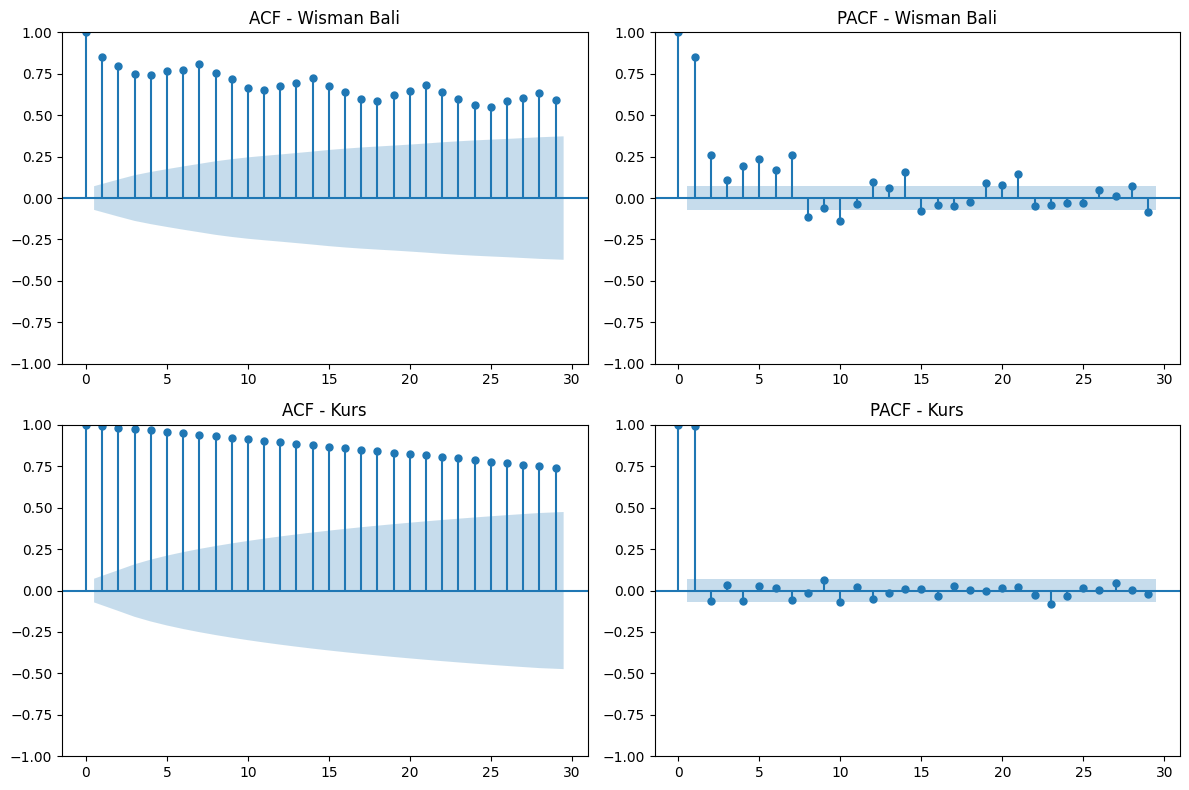

In [12]:
def adf_test(series, signif=0.05):
    stat, p_value, _, _, critical_values, _ = adfuller(series, autolag='AIC')
    return p_value <= signif, {'Test Statistic': stat, 'p-value': p_value, 'Critical Values': critical_values}

stationary_wisman, adf_wisman = adf_test(df_norm['Wisman Bali'])
stationary_kurs, adf_kurs = adf_test(df_norm['Kurs'])
print("Augmented Dickey-Fuller Test")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman, adf_kurs], [stationary_wisman, stationary_kurs]):
    print(f"\n{name}")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm['Wisman Bali'], ax=axes[0, 0], title="ACF - Wisman Bali")
plot_pacf(df_norm['Wisman Bali'], ax=axes[0, 1], title="PACF - Wisman Bali")
plot_acf(df_norm['Kurs'], ax=axes[1, 0], title="ACF - Kurs")
plot_pacf(df_norm['Kurs'], ax=axes[1, 1], title="PACF - Kurs")

plt.tight_layout()
plt.show()


ADF Test Setelah Differencing

Wisman Bali (Setelah Differencing)
   Test Statistic: -9.1489
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.4393396487377155), '5%': np.float64(-2.865507363200066), '10%': np.float64(-2.5688826684180897)}
   Stasioner

Kurs (Setelah Differencing)
   Test Statistic: -8.1313
   p-value: 0.0000
   Critical Values: {'1%': np.float64(-3.4392057325732104), '5%': np.float64(-2.8654483492874236), '10%': np.float64(-2.5688512291811225)}
   Stasioner


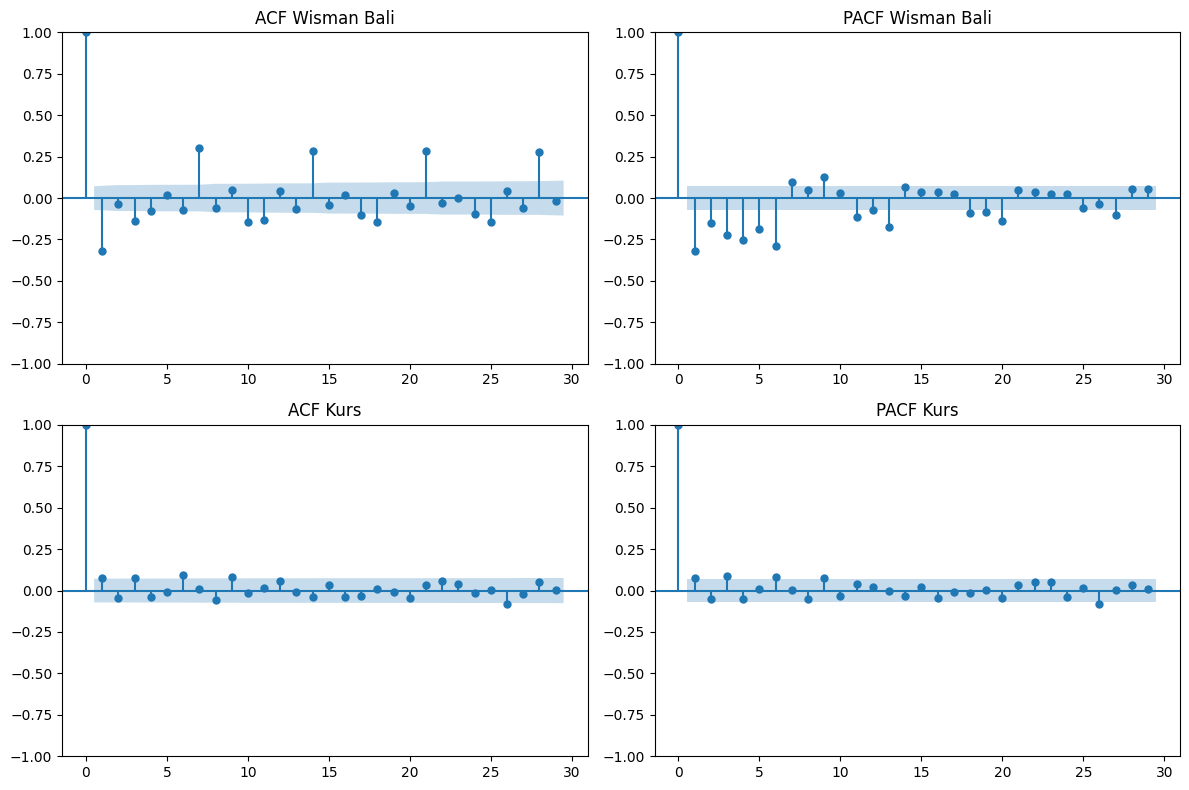

In [13]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

df_norm_diff = df_norm.copy()
df_norm_diff[endog_vars] = df_norm[endog_vars].diff().dropna() # Differencing hanya untuk variabel endogen
df_norm_diff[exog_vars] = df_norm[exog_vars] # Eksogen tetap pakai data aslinya
df_norm_diff = df_norm_diff.dropna()

stationary_wisman_diff, adf_wisman_diff = adf_test(df_norm_diff['Wisman Bali'])
stationary_kurs_diff, adf_kurs_diff = adf_test(df_norm_diff['Kurs'])
print("ADF Test Setelah Differencing")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman_diff, adf_kurs_diff], [stationary_wisman_diff, stationary_kurs_diff]):
    print(f"\n{name} (Setelah Differencing)")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_norm_diff['Wisman Bali'], ax=axes[0, 0], title="ACF Wisman Bali")
plot_pacf(df_norm_diff['Wisman Bali'], ax=axes[0, 1], title="PACF Wisman Bali")
plot_acf(df_norm_diff['Kurs'], ax=axes[1, 0], title="ACF Kurs")
plot_pacf(df_norm_diff['Kurs'], ax=axes[1, 1], title="PACF Kurs")

plt.tight_layout()
plt.show()


## **Modeling**

#####**3 Bulan**

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

# Sliding window 3 bulan
window_size = 90
n_test = 30
n_train = window_size - n_test
shift = 90
n_windows = 8
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())



Window 1 - Evaluasi Lag:
    Lag         AIC         BIC
0     1 -459.789205 -436.751415
1     2 -456.043859 -424.628691
2     3 -455.133746 -415.341199
3     4 -447.745847 -399.575922
4     5 -449.636265 -393.088962
5     6 -447.805446 -382.880765
6     7 -447.308603 -374.006543
7     8 -443.705413 -362.025975
8     9 -455.645695 -365.588879
9    10 -458.680101 -360.245907
10   11 -473.618122 -366.806550
11   12 -471.823580 -356.634630
12   13 -473.697767 -350.131438
13   14 -454.398956 -322.455248
14   15 -460.348237 -320.027151

Window 1 | Best Lag: 13 | AIC: -473.70
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   60
Model:                            VARX(13)   Log Likelihood                 295.849
                               + intercept   AIC                           -473.698
Date:                     Mon, 07 Apr 2025   BIC                           -350.131
Ti

#####**4 Bulan**

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

# Sliding window 4 bulan: 3 bulan train (90), 1 bulan test (30)
window_size = 120
n_train = 90
n_test = 30
shift = 120
n_windows = 6
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())



Window 1 - Evaluasi Lag:
    Lag         AIC         BIC
0     1 -578.229751 -550.731845
1     2 -574.665362 -537.168216
2     3 -572.989264 -525.492880
3     4 -567.408966 -509.913344
4     5 -570.354741 -502.859880
5     6 -568.882547 -491.388447
6     7 -562.681060 -475.187721
7     8 -557.646496 -460.153919
8     9 -551.969559 -444.477743
9    10 -553.331289 -435.840235
10   11 -554.945598 -427.455305
11   12 -557.161286 -419.671754
12   13 -553.461062 -405.972292
13   14 -537.862023 -380.374014
14   15 -536.279503 -368.792255

Window 1 | Best Lag: 1 | AIC: -578.23
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   90
Model:                             VARX(1)   Log Likelihood                 300.115
                               + intercept   AIC                           -578.230
Date:                     Mon, 07 Apr 2025   BIC                           -550.732
Tim

#####**6 Bulan**

In [ ]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

# Sliding window 6 bulan: 5 bulan train (150), 1 bulan test (30)
window_size = 180
n_train = 150
n_test = 30
shift = 180
n_windows = 4
n_total = len(df_norm_diff)

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    # Cari lag optimal (1 sampai 15)
    lag_selection = []
    for lag in range(1, 16):
        try:
            model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
            results = model.fit(disp=False)
            lag_selection.append({
                'Lag': lag,
                'AIC': results.aic,
                'BIC': results.bic
            })
        except Exception as e:
            print(f"Error pada lag {lag} di Window {i+1}: {e}")
            continue

    df_lag = pd.DataFrame(lag_selection)
    print(f"\nWindow {i+1} - Evaluasi Lag:\n{df_lag}")

    if df_lag.empty:
        print(f"Window {i+1}: Tidak ada model yang berhasil difit.")
        continue

    # Pilih lag terbaik (berdasarkan AIC terkecil)
    best_idx = df_lag['AIC'].idxmin()
    best_order = int(df_lag.loc[best_idx, 'Lag'])

    # Fit model akhir
    best_model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(best_order, 0)).fit(disp=False)
    print(f"\nWindow {i+1} | Best Lag: {best_order} | AIC: {best_model.aic:.2f}")
    print(best_model.summary())



Window 1 - Evaluasi Lag:
    Lag          AIC         BIC
0     1 -1030.944876 -997.827888
1     2 -1027.603699 -982.444170
2     3 -1026.601934 -969.399864
3     4 -1023.811707 -954.567096
4     5 -1028.981874 -947.694721
5     6 -1030.523139 -937.193444
6     7 -1024.578915 -919.206680
7     8 -1021.337416 -903.922640
8     9 -1016.002775 -886.545457
9    10 -1012.030831 -870.530972
10   11 -1014.605213 -861.062813
11   12 -1012.920028 -847.335087
12   13 -1010.787925 -833.160443
13   14 -1006.450726 -816.780702
14   15 -1000.594771 -798.882206

Window 1 | Best Lag: 1 | AIC: -1030.94
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  150
Model:                             VARX(1)   Log Likelihood                 526.472
                               + intercept   AIC                          -1030.945
Date:                     Mon, 07 Apr 2025   BIC                      

In [19]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

# Sliding window 6 bulan: 5 bulan train (150), 1 bulan test (30)
window_size = 180
n_train = 150
n_test = 30
shift = 180
n_windows = 4
n_total = len(df_norm_diff)
lag = 7

for i in range(n_windows):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(lag, 0))
        results = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: {lag} | AIC: {results.aic:.2f}")
        print(results.summary())
    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")



Window 1 | Lag: 7 | AIC: -1024.58
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  150
Model:                             VARX(7)   Log Likelihood                 547.289
                               + intercept   AIC                          -1024.579
Date:                     Tue, 08 Apr 2025   BIC                           -919.207
Time:                             05:42:32   HQIC                          -981.770
Sample:                         01-02-2023                                         
                              - 05-31-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.00, 0.03   Jarque-Bera (JB):       85.84, 2790.14
Prob(Q):                        0.99, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.47, 1.4

In [20]:
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Libur Nasional']

# Parameter sliding window 3 bulan
window_size = 90        # 3 bulan data
n_test = 30             # 1 bulan test
n_train = window_size - n_test  # 2 bulan train
shift = 30              # geser per 1 bulan
n_windows1 = 8
n_total = len(df_norm_diff)

mape_kurs_scores = []
mape_wisman_scores = []

for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        print(f"Window {i+1} tidak dapat dibuat karena melebihi batas data.")
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(6, 0))
        best_model = model.fit(disp=False)
        print(f"\nWindow {i+1} | Lag: 6 | AIC: {best_model.aic:.2f}")
        print(best_model.summary())

        # Forecast (masih dalam bentuk normalisasi)
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi forecast dan test data
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Hitung MAPE
        mape_kurs = mean_absolute_percentage_error(test_denorm['Kurs'], forecast_denorm['Kurs'])
        mape_wisman = mean_absolute_percentage_error(test_denorm['Wisman Bali'], forecast_denorm['Wisman Bali'])

        mape_kurs_scores.append(mape_kurs)
        mape_wisman_scores.append(mape_wisman)

        print(f"Window {i+1} MAPE Kurs: {mape_kurs:.4f}, MAPE Wisman: {mape_wisman:.4f}")

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

# Rata-rata MAPE akhir
if mape_kurs_scores and mape_wisman_scores:
    final_mape_kurs = np.mean(mape_kurs_scores)
    final_mape_wisman = np.mean(mape_wisman_scores)
    print(f"\nFinal Average MAPE Kurs: {final_mape_kurs:.4f}")
    print(f"Final Average MAPE Wisman: {final_mape_wisman:.4f}")


Window 1 | Lag: 6 | AIC: -447.81
                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                   60
Model:                             VARX(6)   Log Likelihood                 254.903
                               + intercept   AIC                           -447.805
Date:                     Tue, 08 Apr 2025   BIC                           -382.881
Time:                             07:39:17   HQIC                          -422.410
Sample:                         01-02-2023                                         
                              - 03-02-2023                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.00, 0.13   Jarque-Bera (JB):          38.95, 0.76
Prob(Q):                        0.98, 0.72   Prob(JB):                   0.00, 0.69
Heteroskedasticity (H):         0.29, 0.98

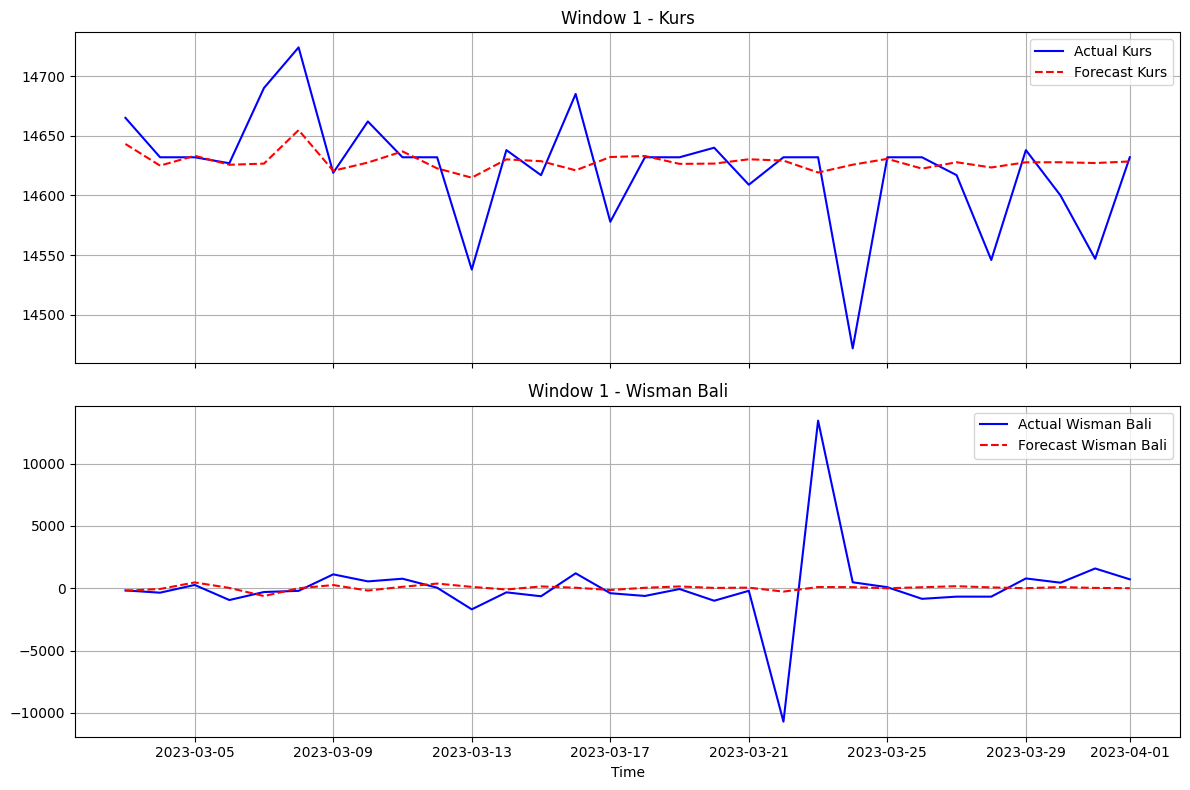

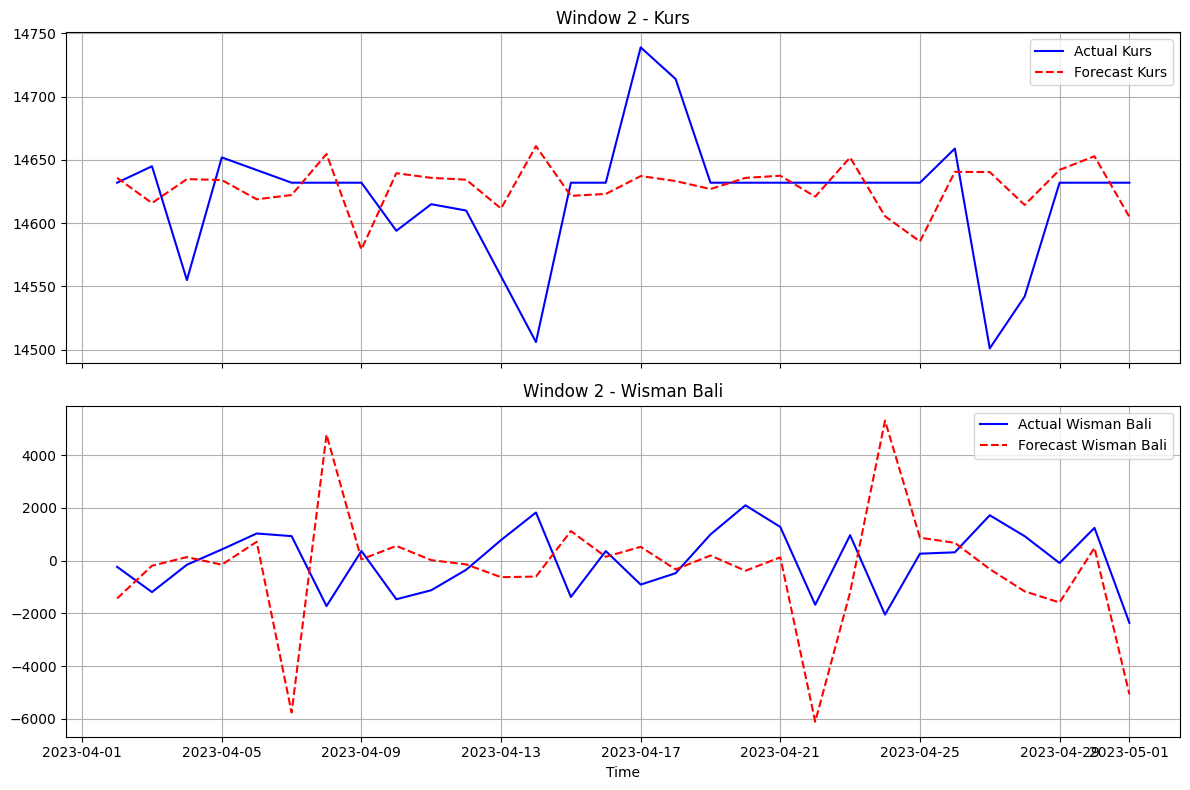

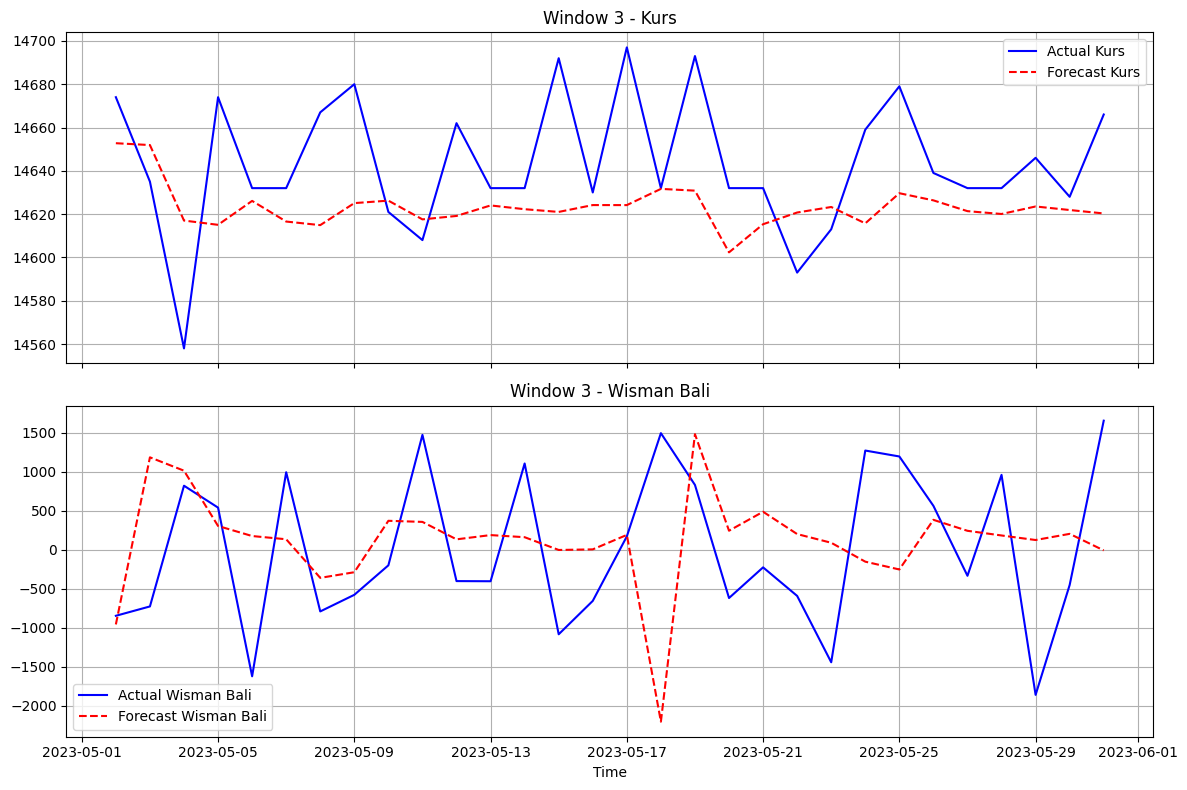

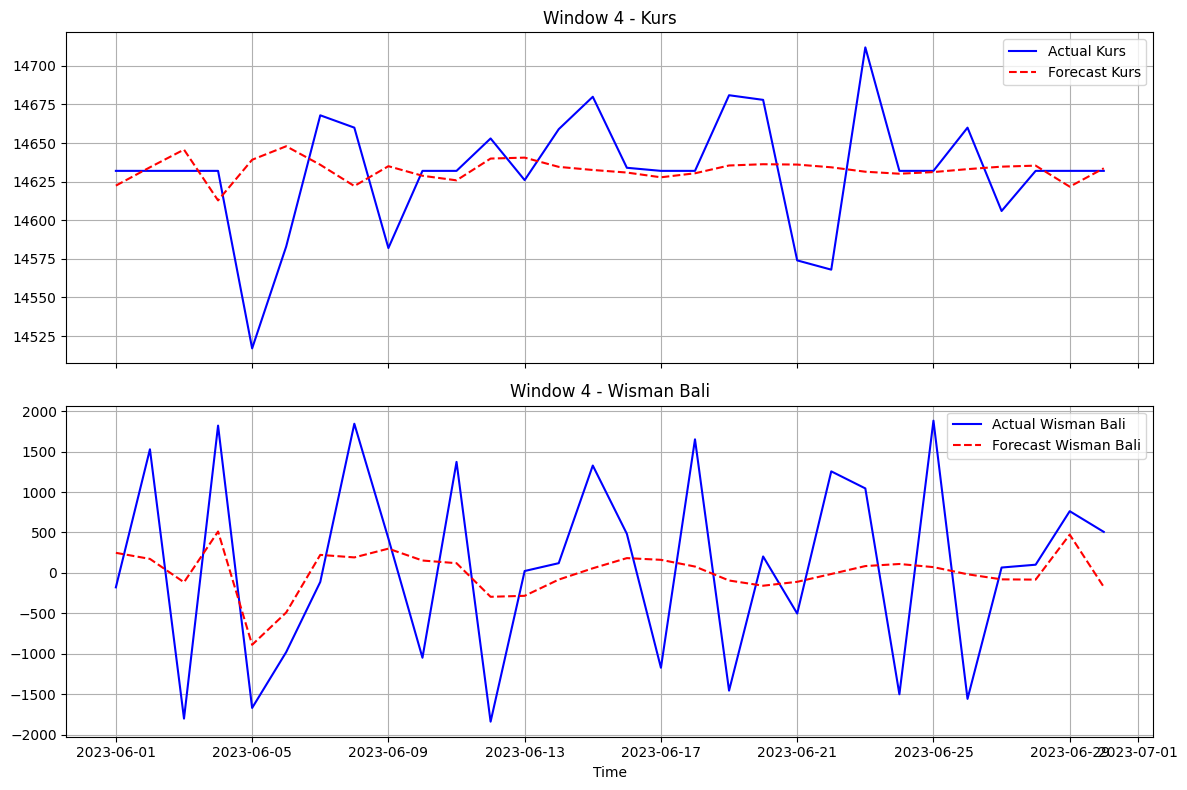

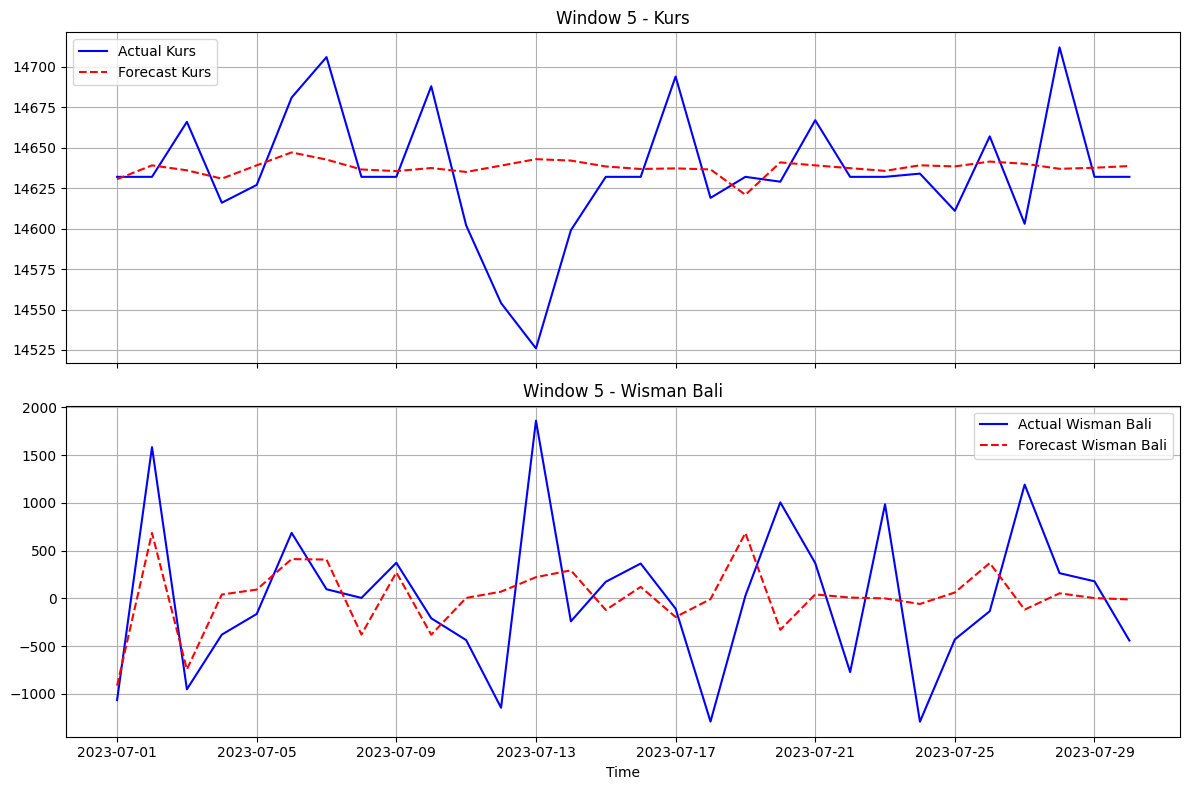

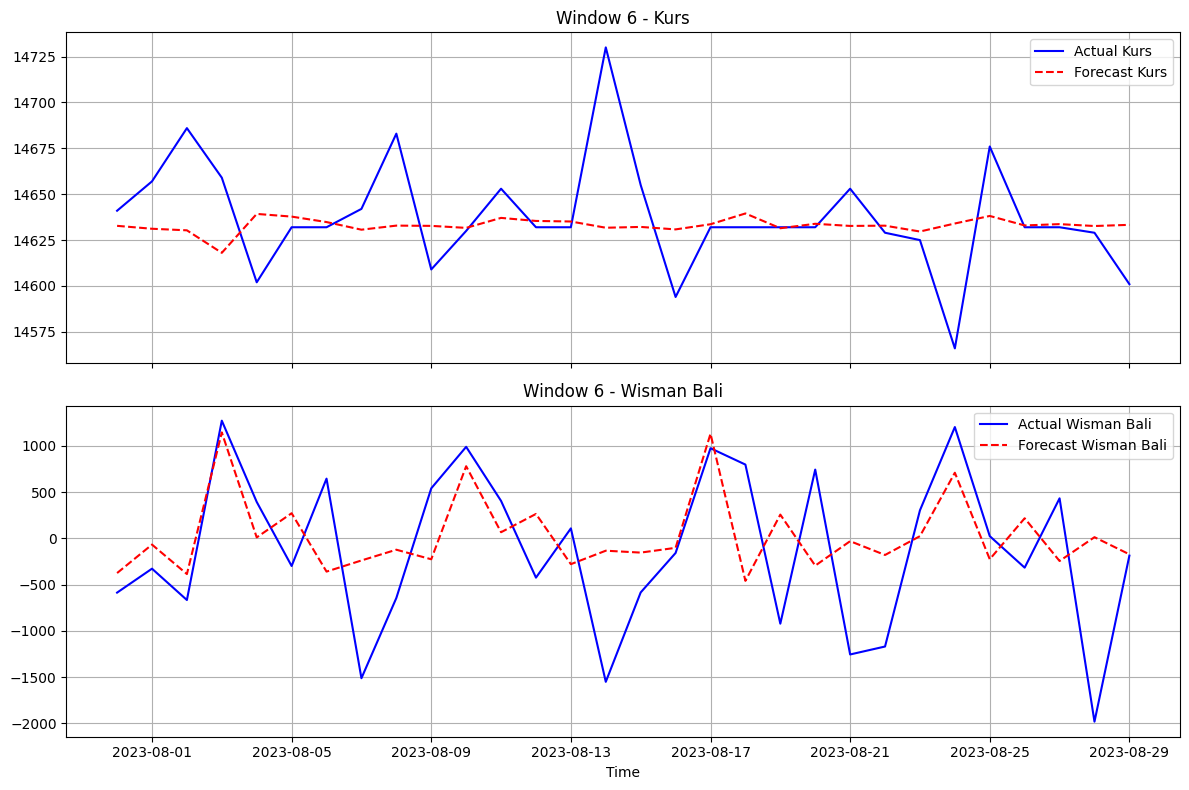

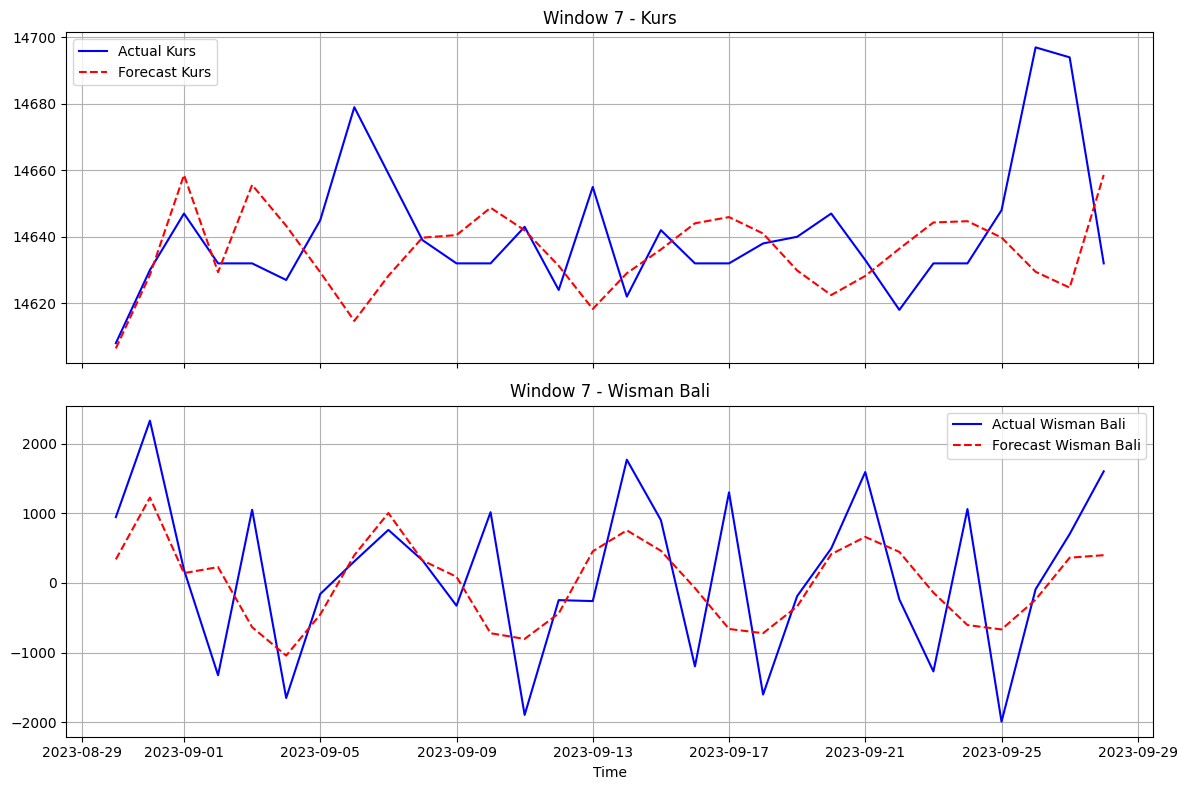

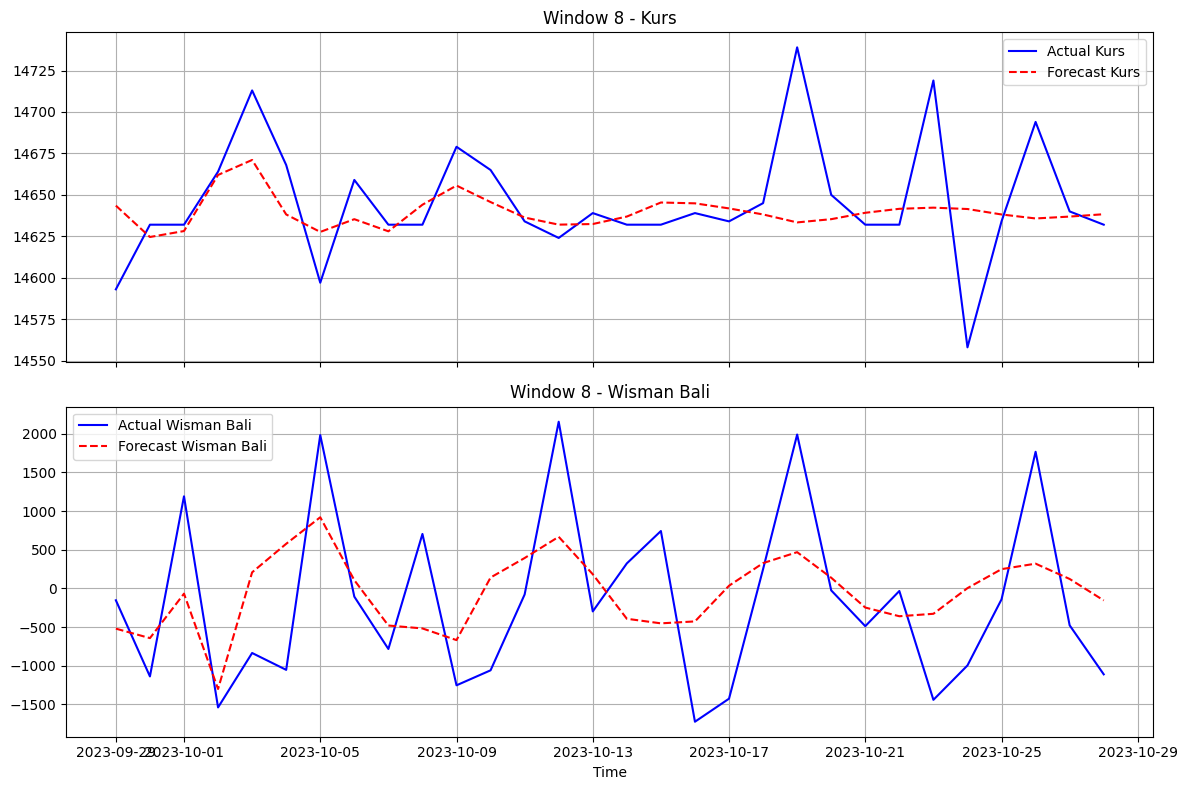

In [21]:
# Loop untuk plot per window
for i in range(n_windows1):
    start = i * shift
    end = start + window_size
    if end > n_total:
        break

    window_data = df_norm_diff.iloc[start:end]
    train = window_data.iloc[:n_train]
    test = window_data.iloc[n_train:]

    try:
        model = VARMAX(train[endog_vars], exog=train[exog_vars], order=(6, 0))
        best_model = model.fit(disp=False)

        # Forecast dengan data normalisasi
        forecast_norm = best_model.forecast(steps=n_test, exog=test[exog_vars])

        # Denormalisasi hasil forecast
        forecast_denorm = pd.DataFrame(scaler.inverse_transform(forecast_norm),
                                       columns=endog_vars, index=test.index)

        # Denormalisasi test data
        test_denorm = pd.DataFrame(scaler.inverse_transform(test[endog_vars]),
                                   columns=endog_vars, index=test.index)

        # Plot hasil forecast vs data aktual
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

        for j, var in enumerate(endog_vars):
            axes[j].plot(test_denorm.index, test_denorm[var], label=f'Actual {var}', color='blue')
            axes[j].plot(forecast_denorm.index, forecast_denorm[var], label=f'Forecast {var}', color='red', linestyle='dashed')
            axes[j].set_title(f'Window {i+1} - {var}')
            axes[j].legend()
            axes[j].grid()

        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error pada Window {i+1}: {e}")
        continue

In [24]:
# Fit Model VARX(6,0) di seluruh data
best_model = VARMAX(df_norm_diff[endog_vars], exog=df_norm_diff[exog_vars], order=(6, 0)).fit(disp=False)

# Ambil residual dari model
residuals = best_model.resid
print(residuals.head())  # Tampilkan 5 baris pertama


                Kurs  Wisman Bali
Date                             
2023-01-02 -0.011629     0.070313
2023-01-03  0.011693     0.013217
2023-01-04  0.010907    -0.000534
2023-01-05 -0.002663     0.073490
2023-01-06  0.013876    -0.009314


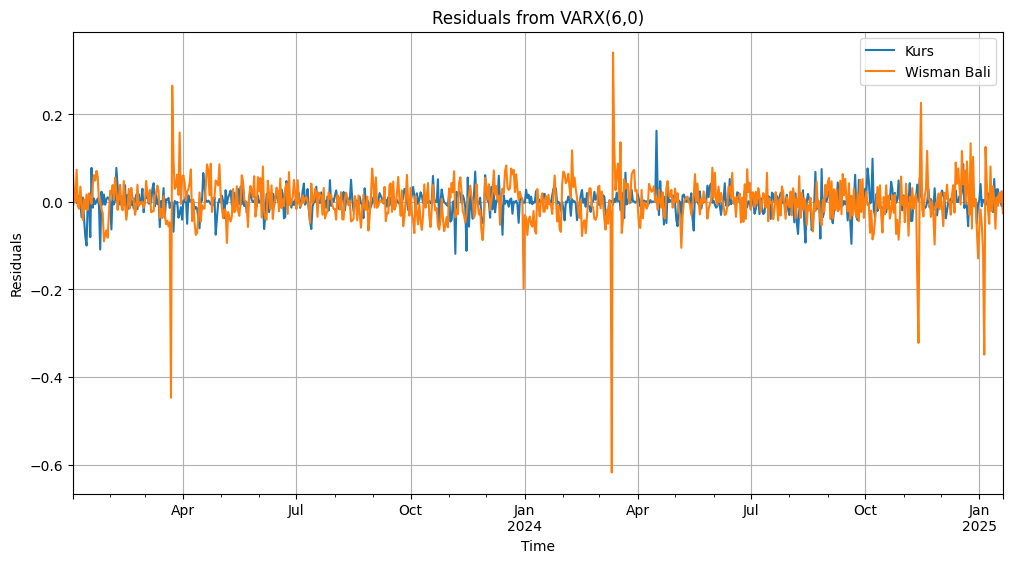

In [25]:
residuals.plot(figsize=(12, 6), title='Residuals from VARX(6,0)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [28]:
residuals.to_csv('residualnas_varx6.csv', index=True)

In [33]:
residualnas_df = pd.read_csv('residualnas_varx6.csv', index_col=0, parse_dates=True)
print(residualnas_df.head())
exog = df_norm_diff.loc[residualnas_df.index, 'Hari Libur Nasional']
resid_all = pd.concat([residualnas_df, exog], axis=1)
print(resid_all.head())

                Kurs  Wisman Bali
Date                             
2023-01-02 -0.011629     0.070313
2023-01-03  0.011693     0.013217
2023-01-04  0.010907    -0.000534
2023-01-05 -0.002663     0.073490
2023-01-06  0.013876    -0.009314
                Kurs  Wisman Bali  Hari Libur Nasional
Date                                                  
2023-01-02 -0.011629     0.070313                    0
2023-01-03  0.011693     0.013217                    0
2023-01-04  0.010907    -0.000534                    0
2023-01-05 -0.002663     0.073490                    0
2023-01-06  0.013876    -0.009314                    0
